In [1]:
import refinitiv.data as rd
import pandas as pd
import matplotlib.pyplot as plt

security = 'NZDJPY='
date_0 = '2023-12-08'
date_1 = '2024-12-08'

rd.open_session()
markets = rd.get_history(universe=[security], fields=['MID_OPEN', 'MID_HIGH', 'MID_LOW','MID_PRICE'],
                         interval="1h", start=date_0, end=date_1
                    )

df = markets

In [2]:
# Conversion line (tenkan)
period9_high = df['MID_HIGH'].rolling(window=9).max()
period9_low = df['MID_LOW'].rolling(window=9).min()
df['conv'] = (period9_high + period9_low) / 2

# Base line (kijun)
period26_high = df['MID_HIGH'].rolling(window=26).max()
period26_low = df['MID_LOW'].rolling(window=26).min()
df['base'] = (period26_high + period26_low) / 2

# Leading A (senkou span A, cloud)
df['cloud1'] = ((df['conv']+df['base'])/2).shift(25)

# Leading B (senkou span B, cloud)
period52_high = df['MID_HIGH'].rolling(window=52).max()
period52_low = df['MID_LOW'].rolling(window=52).min()
df['cloud2'] = ((period52_high + period52_low) / 2).shift(25)
# this means the first 76 rows would have NA value under cloud2 column

# Leading A (senkou span A, future)
df['lead1'] = (df['conv']+df['base'])/2

# Leading B (senkou span B, future)
df['lead2'] = (period52_high + period52_low) / 2

# Lag (chikou)
# df['lag'] = df['MID_PRICE'].shift(-24)
# instead of comparing lagged line with historical price
# I shift the historical price foward to compare with the currency price
df['hist_price'] = df['MID_PRICE'].shift(25)

df = df.dropna()
df = df.drop(['MID_HIGH','MID_LOW'], axis=1)
df['signal'] = 'flat'


In [3]:
for i in df.index:
    if all([df.loc[i]['conv'] > df.loc[i]['base'],
            df.loc[i]['lead1'] > df.loc[i]['lead2'],
            df.loc[i]['MID_PRICE'] > df.loc[i]['cloud1'],
            df.loc[i]['cloud1'] > df.loc[i]['cloud2'],
            df.loc[i]['MID_PRICE'] > df.loc[i]['hist_price']]):
        df.loc[i,['signal']] = 'long'
    else: continue
    
# check for short signal
for i in df.index:
    if all([df.loc[i]['conv'] < df.loc[i]['base'],
            df.loc[i]['lead1'] < df.loc[i]['lead2'],
            df.loc[i]['MID_PRICE'] < df.loc[i]['cloud1'],
            df.loc[i]['cloud1'] < df.loc[i]['cloud2'],
            df.loc[i]['MID_PRICE'] < df.loc[i]['hist_price']]):
        df.loc[i,['signal']] = 'short'
    else: continue

In [4]:
entry = 0
position = 0
pnl = []

for i in df.index:
    if df.loc[i]['signal'] == 'long':
        if position == 0:
            entry = df.loc[i]['MID_OPEN']
            position = 1
            continue
        elif position == -1:
            pnl.append(df.loc[i]['MID_PRICE'] - entry)
            entry = 0
            position = 0
            continue
        else: continue
    elif df.loc[i]['signal'] == 'short':
        if position == 0:
            entry = df.loc[i]['MID_OPEN']
            position = -1
            continue
        elif position == 1:
            pnl.append(entry - df.loc[i]['MID_PRICE'])
            entry = 0
            position = 0
            continue
        else: continue
    elif df.loc[i]['signal'] == 'flat':
        if position == 0:
            continue
        elif position == 1:
            pnl.append(df.loc[i]['MID_PRICE'] - entry)
            entry = 0
            position = 0
            continue
        else: 
            pnl.append(entry - df.loc[i]['MID_PRICE'])
            entry = 0
            position = 0
            continue

In [5]:
display({'total pnl':round(sum(pnl),2), 
 'No. of trades': len(pnl),
 'maximum drawdown':round(min(pnl),2), 
 'maximum gain':round(max(pnl),2), 
 'win rate': round(sum(x>0 for x in pnl)/len(pnl),2), 
 'gain/loss ratio':abs(round(sum(x for x in pnl if x>0)/sum(x for x in pnl if x<0),2))})

{'total pnl': 20.79,
 'No. of trades': 180,
 'maximum drawdown': -0.63,
 'maximum gain': 4.09,
 'win rate': 0.52,
 'gain/loss ratio': 2.33}

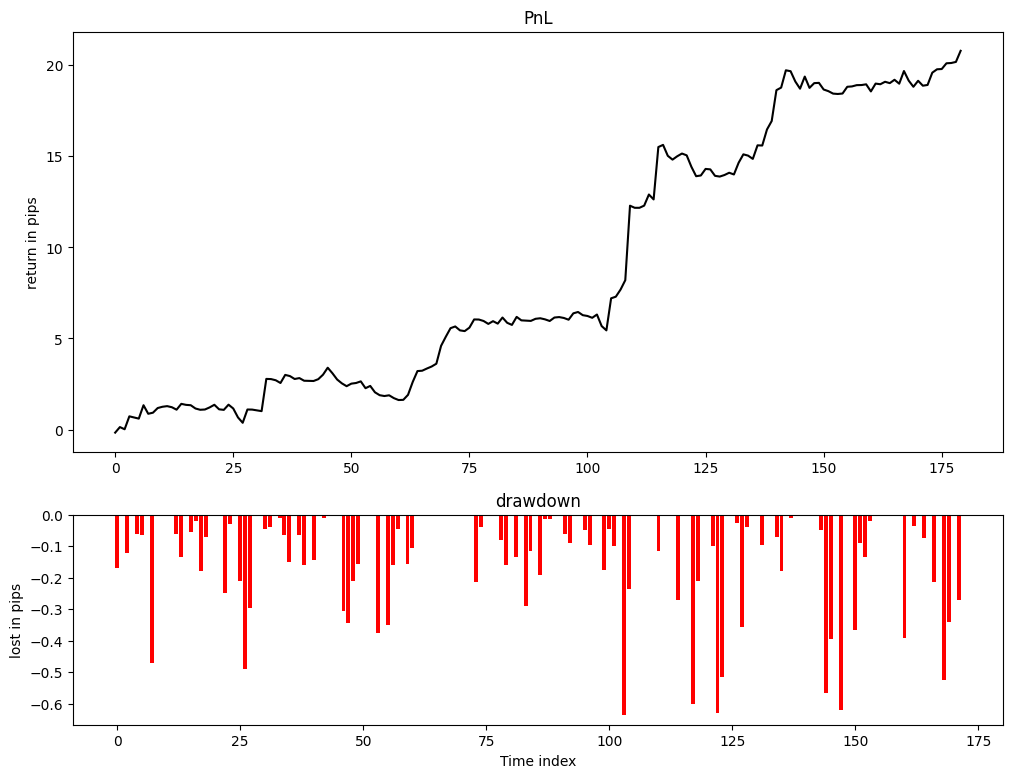

In [6]:
pnl_df = pd.DataFrame(pnl, columns=['pnl in pips'])
pnl_df['cum'] = pnl_df['pnl in pips'].cumsum()
pnl_df['drawdown'] = pnl_df.loc[pnl_df['pnl in pips'] < 0, 'pnl in pips']

fig, axs = plt.subplots(2, figsize=(12,9), gridspec_kw={'height_ratios':[2,1]})

axs[0].plot(pnl_df['cum'], color='black')
axs[0].set_title('PnL')
# axs[0].set_xlabel('Time')
axs[0].set_ylabel('return in pips')

axs[1].bar(pnl_df.index, pnl_df['drawdown'], color='red')
axs[1].set_title('drawdown')
axs[1].set_xlabel('Time index')
axs[1].set_ylabel('lost in pips')

plt.show()